# EDA

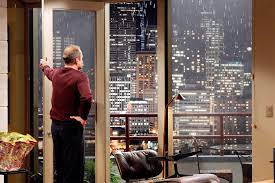

In [1]:
import warnings

warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 # to connect to SQL database

from matplotlib.ticker import PercentFormatter
plt.rcParams.update({ "figure.figsize" : (8, 5),"axes.facecolor" : "white", "axes.edgecolor":  "black"})
plt.rcParams["figure.facecolor"]= "w"
pd.plotting.register_matplotlib_converters()
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [2]:
import os # provides functions for interacting with operating system
from dotenv import load_dotenv # reads key-value pairs from a .env file and can set them as environment variables

load_dotenv() # takes environment variables from .env

DATABASE = os.getenv('DATABASE')
USER_DB = os.getenv('USER_DB')
PASSWORD = os.getenv('PASSWORD')
HOST = os.getenv('HOST')
PORT = os.getenv('PORT')

The data is read into a dataframe and then cleaned. But first, some informationa about the data is needed. Therefore, all columnsa and data types are displayed.

In [3]:
#export the data to a csv-file
df_houses=pd.read_csv("joined_house_tables.csv")
df_houses.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21597 entries, 0 to 21596
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21597 non-null  int64  
 1   bedrooms       21597 non-null  float64
 2   bathrooms      21597 non-null  float64
 3   sqft_living    21597 non-null  float64
 4   sqft_lot       21597 non-null  float64
 5   floors         21597 non-null  float64
 6   waterfront     19206 non-null  float64
 7   view           21534 non-null  float64
 8   condition      21597 non-null  int64  
 9   grade          21597 non-null  int64  
 10  sqft_above     21597 non-null  float64
 11  sqft_basement  21145 non-null  float64
 12  yr_built       21597 non-null  int64  
 13  yr_renovated   17749 non-null  float64
 14  zipcode        21597 non-null  int64  
 15  lat            21597 non-null  float64
 16  long           21597 non-null  float64
 17  sqft_living15  21597 non-null  float64
 18  sqft_l

In [4]:
#view some sample data through the first rows
df_houses.head()

id  bedrooms  bathrooms  sqft_living  sqft_lot  floors  waterfront  \
0  7129300520     3.000      1.000     1180.000  5650.000   1.000         NaN   
1  6414100192     3.000      2.250     2570.000  7242.000   2.000       0.000   
2  5631500400     2.000      1.000      770.000 10000.000   1.000       0.000   
3  2487200875     4.000      3.000     1960.000  5000.000   1.000       0.000   
4  1954400510     3.000      2.000     1680.000  8080.000   1.000       0.000   

   view  condition  grade  ...  sqft_basement  yr_built  yr_renovated  \
0 0.000          3      7  ...          0.000      1955         0.000   
1 0.000          3      7  ...        400.000      1951     19910.000   
2 0.000          3      6  ...          0.000      1933           NaN   
3 0.000          5      7  ...        910.000      1965         0.000   
4 0.000          3      8  ...          0.000      1987         0.000   

   zipcode    lat     long  sqft_living15  sqft_lot15        date      price  
0    98178 47.511 -122.257       1340.000    5650.000  2014-10-13 221900.000  
1    98125 47.721 -122.319       1690.000    7639.000  2014-12-09 538000.000  
2    98028 47.738 -122.233       2720.000    8062.000  2015-02-25 180000.000  
3    98136 47.521 -122.393       1360.000    5000.000  2014-12-09 604000.000  
4    98074 47.617 -122.045       1800.000    7503.000  2015-02-18 510000.000  

[5 rows x 21 columns]

In [5]:
# check for duplicate rows
df_houses.duplicated().value_counts()

False    21597
Name: count, dtype: int64

In [ ]:
#no duplycate rows

#the info displayed that the date column is marked as object
#in case it is needed, it is changed into another format

#check data type for date(makred as object) and change it into a timestep format
type(df_houses['date'][0]) 

str

In [8]:
df_houses['date']

0        2014-10-13
1        2014-12-09
2        2015-02-25
3        2014-12-09
4        2015-02-18
            ...    
21592    2014-05-21
21593    2015-02-23
21594    2014-06-23
21595    2015-01-16
21596    2014-10-15
Name: date, Length: 21597, dtype: object

In [9]:
df_houses['date'] = pd.to_datetime(df_houses['date'], format='%Y-%m-%d')
type(df_houses['date'][0])

pandas._libs.tslibs.timestamps.Timestamp

In [11]:
#check if any data is missing

import missingno as msno
# display number of missing values per column
df_houses.isna().sum()


id                  0
bedrooms            0
bathrooms           0
sqft_living         0
sqft_lot            0
floors              0
waterfront       2391
view               63
condition           0
grade               0
sqft_above          0
sqft_basement     452
yr_built            0
yr_renovated     3848
zipcode             0
lat                 0
long                0
sqft_living15       0
sqft_lot15          0
date                0
price               0
dtype: int64

In a couple columns a lot of data is missing. To get an overwiev about the missing data it is visualized. The white lines in the following plot equal a missing row.

<Axes: >

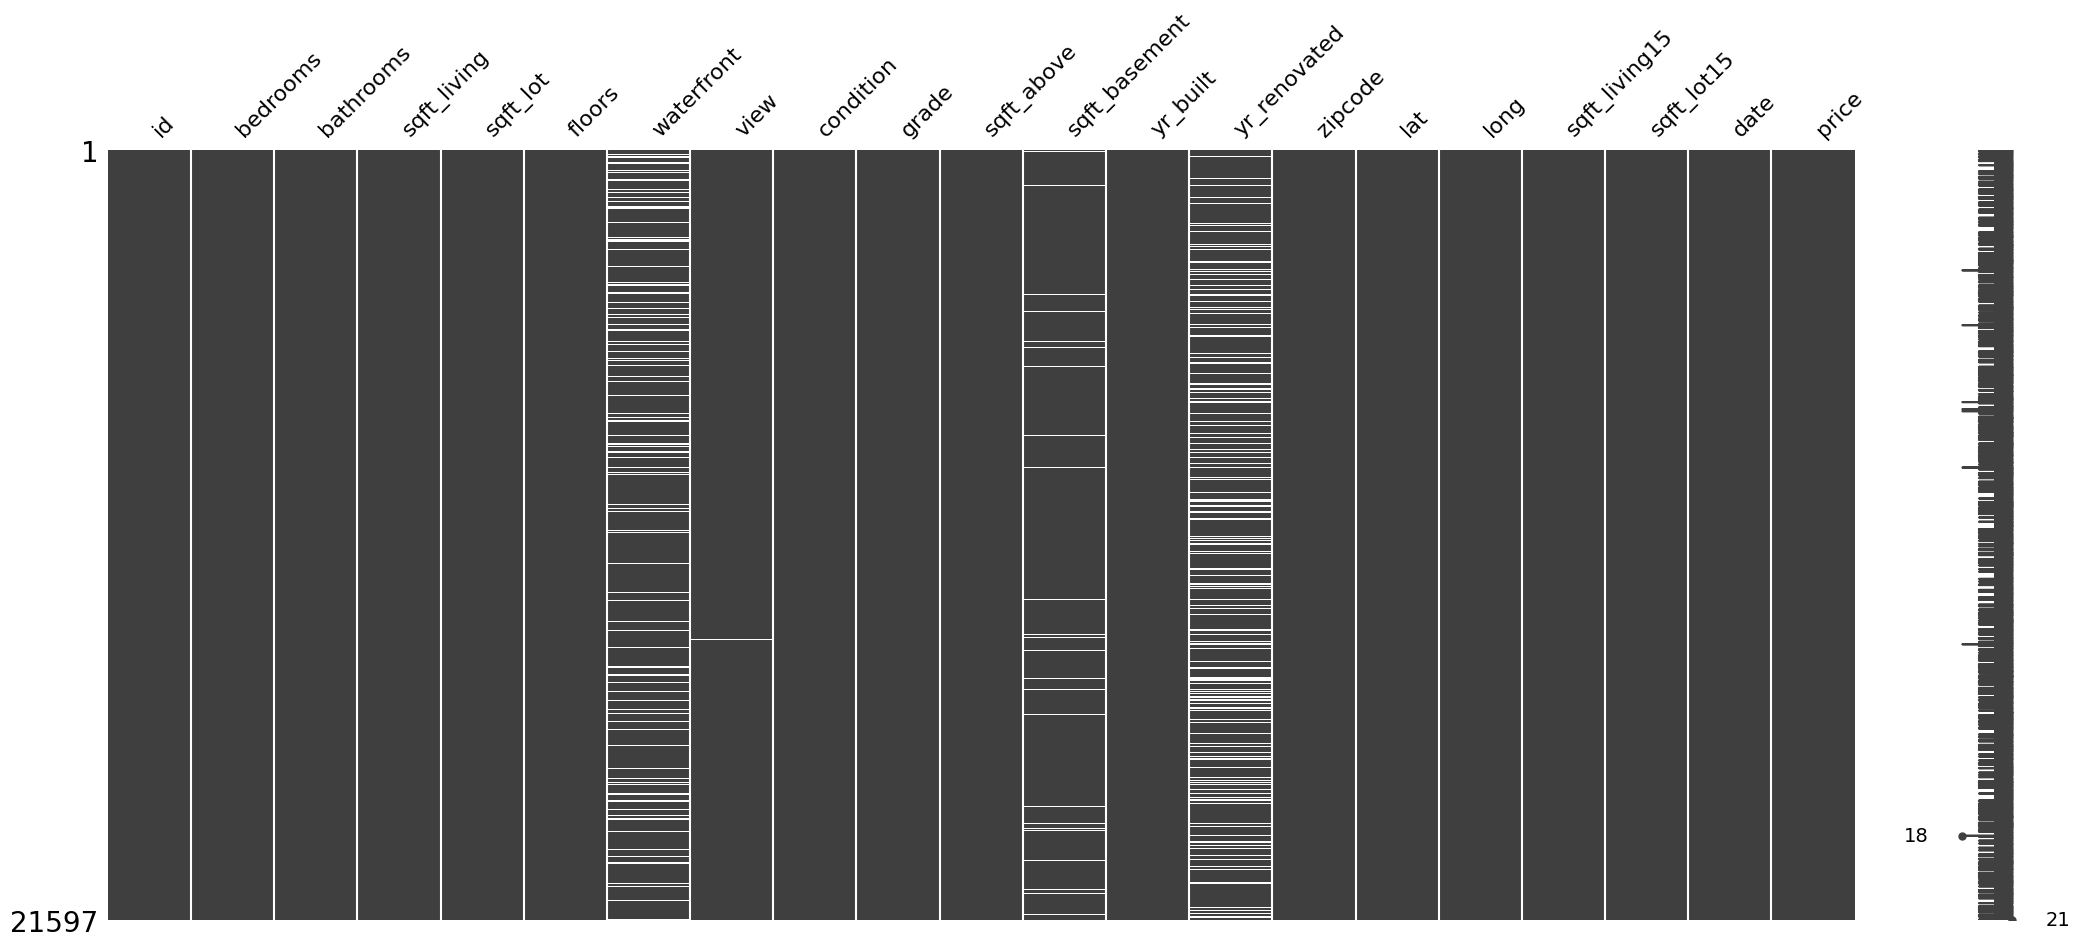

In [12]:
msno.matrix(df_houses)

The columns waterfront, sqft_basement, and yr_renovated contain a considerable amount of missing data.
Our client, Larry Sanders, is specifically interested in properties by the waterfront, which unfortunately happens to be one of the least complete features in the dataset.
Therefore, **the first step of this analysis focuses on identifying all houses located at the waterfront**.
From there, the data is explored further to reflect Larry’s personal preferences. He has a limited budget, values a quiet and somewhat isolated home, and prefers to live in a central neighborhood without kids. He has kids himself, but is cautious about germs and therefore does not want to play his kids with other kids.



To get some further information about the data a scatter matrix plot is displayed. Since the data set is very large, 150 random sample data is used. Further, a kernal density estimate (kde) is displayed. A KDE is a smoothed version of a histogram. The color scale displays the grade (quality of construction and design). The higher the grade, the darker the color.

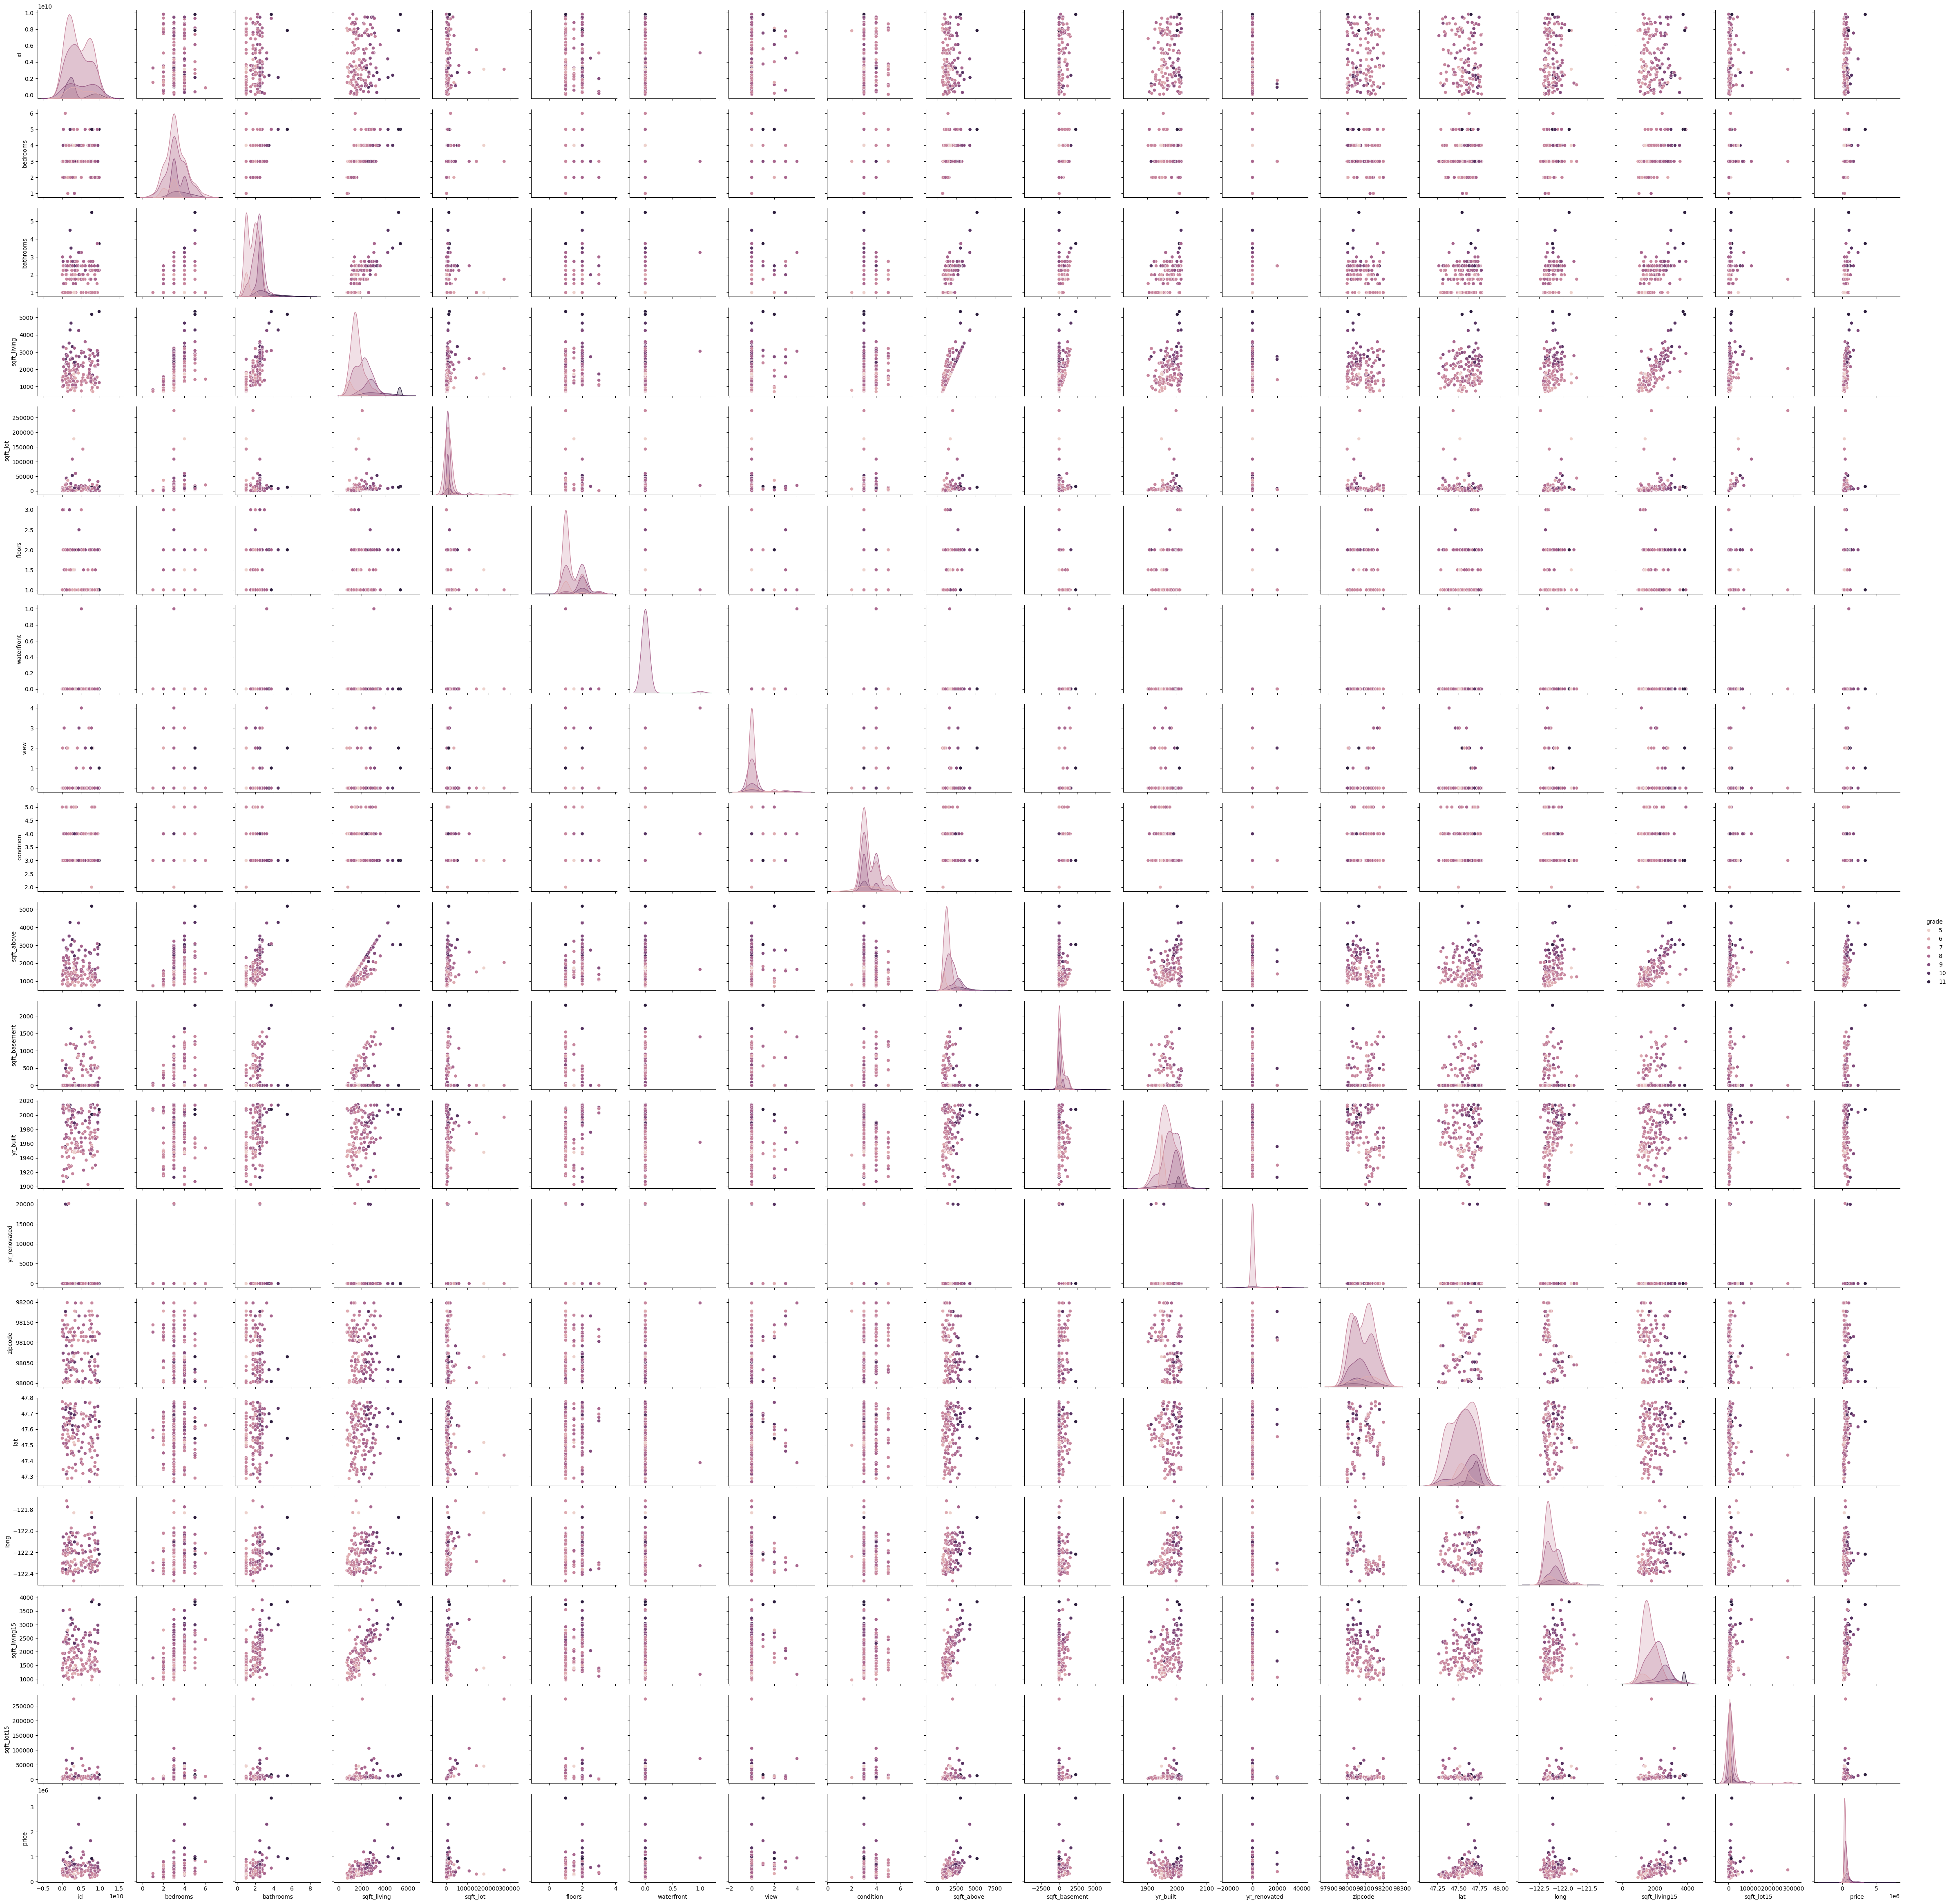

In [13]:
import matplotlib.pyplot as plt 
import seaborn as sns
pair=sns.pairplot(df_houses.sample(150), hue="grade", diag_kind="kde") 
plt.show()

Viewing the plots, some insights in the data become visisble. 

- The higher the amount of sqft, the higher is the grading of the home.
- In the 2000er a lot of houses got into the portfolio, that are more luxusurious. Before the sold houses where more basic.
- There can be found multiple houses with a very good condition, for a reasonable price.
-There are far less houses at the waterfront, than not.
- The houses with the highest grading are at the zip codes from 98000 to 9855.

---
## Let's start by finding all houses at the waterfront 

To find the all the houses at the waterfront, the according column is examined.

In [14]:
#look into how the inforatin is stored in the column
print(df_houses["waterfront"].unique())
df_houses["waterfront"].value_counts()

[nan  0.  1.]


waterfront
0.000    19060
1.000      146
Name: count, dtype: int64

In [15]:
#a new data frame is created,that only has the houses at the waterfront
df_waterfront=df_houses[df_houses["waterfront"] == 1]
print(df_waterfront)

               id  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
49      822039084     3.000      2.500     2753.000 65005.000   1.000   
230    8096000060     2.000      1.750     1450.000 15798.000   2.000   
246    2025069065     4.000      2.500     3650.000  8354.000   1.000   
264    2123039032     1.000      0.750      760.000 10079.000   1.000   
300    3225069065     4.000      5.000     4550.000 18641.000   1.000   
...           ...       ...        ...          ...       ...     ...   
19968  2025069140     3.000      2.500     2830.000  4334.000   3.000   
20309   518500480     3.000      3.500     4410.000 10756.000   2.000   
20751  8043700105     4.000      4.000     4360.000  8175.000   2.500   
21185   518500460     3.000      3.500     3760.000  5634.000   2.000   
21560  9253900271     5.000      4.500     4850.000 10584.000   2.000   

       waterfront  view  condition  grade  ...  sqft_basement  yr_built  \
49          1.000 2.000          5      9  ...  

In [16]:
#sort the houses that have no informationa about a waterfront
df_waterfront_unknown=df_houses[df_houses["waterfront"].isna()]

#overview how man houses have a waterfront 
print("houses")
print(len(df_houses))
print("waterfront")
print(len(df_waterfront))
print("unknown")
print(len(df_waterfront_unknown))

#how many houses have knowingly no waterfront
df_no_waterfront=df_houses[df_houses["waterfront"] == 0]
print("no waterfront")
print(len(df_no_waterfront))

houses
21597
waterfront
146
unknown
2391
no waterfront
19060


---
To find the best house for Larry, the dataset should not just be filtered randomly. 

With the help of hypotheses, the data is examined with structure. The analysis data can display trad-offs for our client. That way the client can be provied with option that display what he can get for his money.

---

<span style="color:darkorange">
Hypothese 1: houses at the waterfront have more squarefeet (are larger)
</span>

Larry wants something nice and isolated. If the data shows that waterfront houses tend to be larger, then it’s a good sign that waterfront also implies spaciousness and something more isolated.

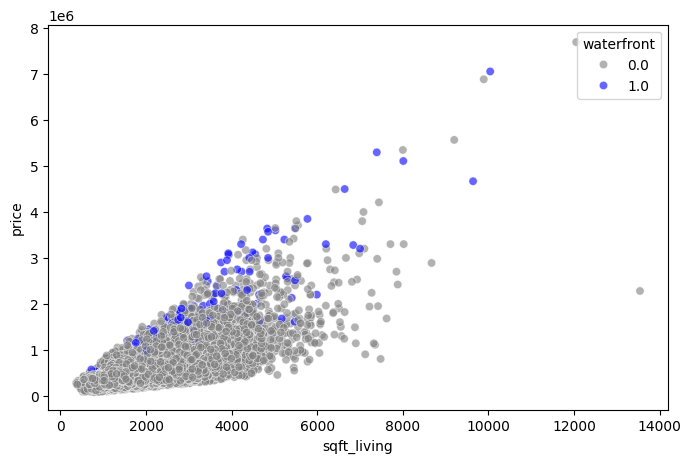

In [ ]:
#first only the houses with water front a sort out
filtered_waterfront = df_houses[(df_houses['waterfront'] == 0) | (df_houses["waterfront"] == 1)]
count=filtered_waterfront.groupby(['waterfront']).size()

#count.plot(kind='bar', stacked=True, figsize=(10, 6), xlabel="df_houses", ylabel="price")
sns.scatterplot(
    data=filtered_waterfront,
    x="sqft_living",
    y="price",
    hue="waterfront",
    palette={0:"grey", 1:"blue"},
    alpha=0.6
)
plt.show()

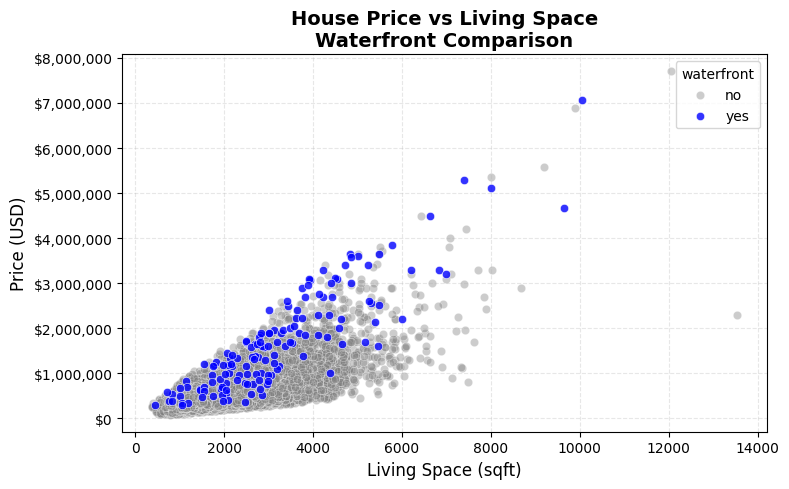

In [24]:
# first plot are all non-waterfront houses
from matplotlib.ticker import FuncFormatter
# grey(waterfront = 0)
sns.scatterplot(
    data=filtered_waterfront[filtered_waterfront["waterfront"] == 0],
    x="sqft_living",
    y="price",
    color="grey",
    marker="o",
    alpha=0.4,
    label="no",
    zorder=1 # forces plot in front
)

#blue (waterfront = 1)
sns.scatterplot(
    data=filtered_waterfront[filtered_waterfront["waterfront"] == 1],
    x="sqft_living",
    y="price",
    color="blue",
    marker="o",
    alpha=0.8,
    label="yes",
    zorder=2 
)


# axes and formating
plt.title("House Price vs Living Space\nWaterfront Comparison", fontsize=14, weight="bold")
plt.xlabel("Living Space (sqft)", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend(title="waterfront")

formatter = FuncFormatter(lambda x, _: f"${x:,.0f}") #forces price format
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()
plt.show()


<span style="color:darkgreen">
=> This plot already confirms the hypothese. 
</span>

To get more into depth, histograms about the absolute data is plotted.

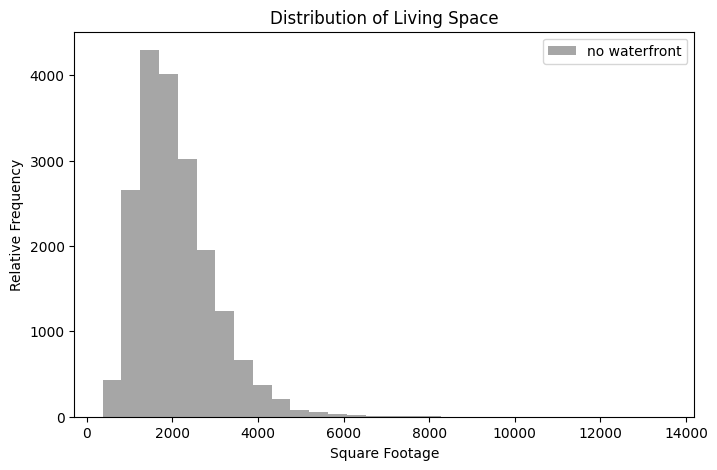

In [37]:
plt.figure(figsize=(8,5))
plt.hist(
    [df_houses[df_houses["waterfront"]==0]["sqft_living"]],
    bins=30,
    color=["grey"],
    label=["no waterfront"],
    alpha=0.7
)
plt.legend()
plt.xlabel("Square Footage")
plt.ylabel("Relative Frequency")
plt.title("Distribution of Living Space")
plt.show()


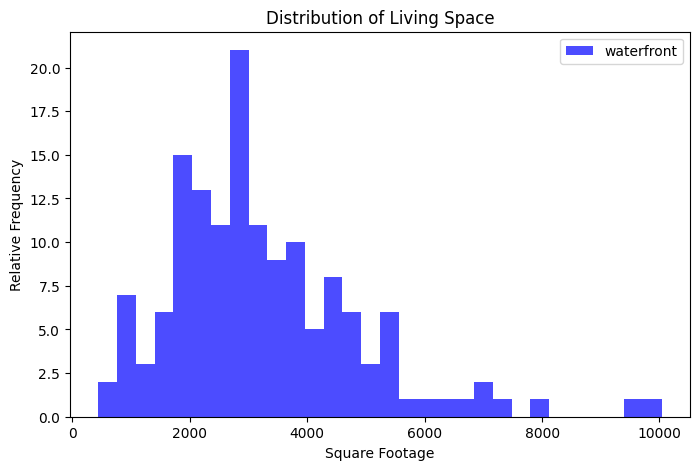

In [40]:
plt.figure(figsize=(8,5))
plt.hist(
    [df_houses[df_houses["waterfront"]==1]["sqft_living"]],
    bins=30,
    color=["blue"],
    label=["waterfront"],
    alpha=0.7
)
plt.legend()
plt.xlabel("Square Footage")
plt.ylabel("Relative Frequency")
plt.title("Distribution of Living Space")
plt.show()


Since the values differ very much, the data is standardized. Then it can be plotted into one graph. 

In [262]:
df_houses_normierte_Waterfront=df_houses["waterfront"]/df_waterfront["waterfront"].sum()
df_houses_normierte_Waterfront.unique()

array([       nan, 0.        , 0.00684932])

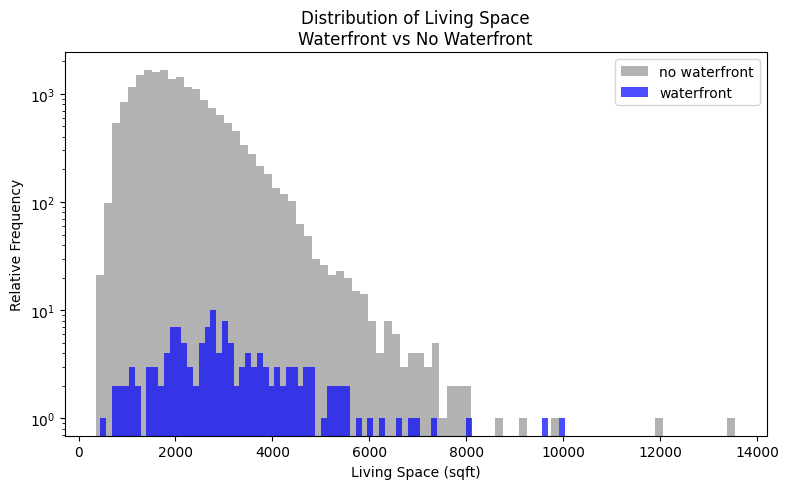

In [41]:
plt.figure(figsize=(8, 5))

# Histogramm without waterfront
plt.hist(
    df_houses[df_houses["waterfront"] == 0]["sqft_living"],
    bins=80,
    color="grey",
    alpha=0.6,
    label="no waterfront"
)

# Histogramm with waterfront
plt.hist(
    df_houses[df_houses["waterfront"] == 1]["sqft_living"],
    bins=80,
    color="blue",
    alpha=0.7,
    label="waterfront"
)

plt.legend()
plt.xlabel("Living Space (sqft)")
plt.ylabel("Relative Frequency")
plt.yscale("log")  # logarithmische Y-Achse, falls nötig
plt.title("Distribution of Living Space\nWaterfront vs No Waterfront")
plt.tight_layout()
plt.show()


This nicely displays the houses with and without waterfront regarding their relative frequency. This plot might be to technical for non-technical stake-holders.

---
<span style="color:darkorange">
Hypothese 2: houses at the waterfront have rearly a basement
</span>

This hypotheses might help to set realistic expectations, if true.

In [44]:
# sort out the basment data for all houses at the waterfront
df_known_basements= df_houses.dropna(subset=["sqft_basement"])

In [45]:
#drop all rows with NaN in the basement column
df_no_waterfront_known_basement=df_no_waterfront.dropna(subset=["sqft_basement"])
df_waterfront_known_basement=df_waterfront.dropna(subset=["sqft_basement"])

In [46]:
#check how many houses remain
len(df_waterfront_known_basement)

142

146 houses have a waterfront. With basement it are 142 houses. So nearly all.
How many basements are present relative to the number of houses can also be represented in percent.

In [47]:
has_basement=df_houses["sqft_basement"].notna()
#gives information back to the dataframe as new column
df_houses["has_basement"]=has_basement

In [48]:
df_houses.groupby("waterfront")["has_basement"].mean()

waterfront
0.000   0.978
1.000   0.973
Name: has_basement, dtype: float64

In [49]:
basement_contingency=pd.crosstab(df_houses["waterfront"],df_houses["has_basement"])
print(basement_contingency)

has_basement  False  True 
waterfront                
0.000           411  18649
1.000             4    142


In [52]:
percentages = basement_contingency.div(basement_contingency.sum(axis=1), axis=0) * 100
print(percentages)

has_basement  False  True 
waterfront                
0.000         2.156 97.844
1.000         2.740 97.260


The Chi²-test displays if there is a statistic correlation between waterfront lovation and basements. While the percent value already shows that there is no correlation, the chi²-test displays this in a meaningful way.

For the chi²-test the nullhypothesis is: basement and waterfront are independen from each other. The alternative hypothesis is: There is a correlation.

In [51]:
from scipy.stats import chi2_contingency

chi2, p, dof, expected = chi2_contingency(basement_contingency)

print("Chi²-value:", chi2)
print("p-value:", p)
print("degrees of freedom:", dof)
print("expected frequencies:\n", expected)

Chi²-value: 0.03891537672120714
p-value: 0.8436164056532625
degrees of freedom: 1
expected frequencies:
 [[4.11845257e+02 1.86481547e+04]
 [3.15474331e+00 1.42845257e+02]]


p-Wert is **not** statistical significant. Thereby, there is no correlation between basement and waterfront.



<span style="color:darkred">
=> There is no correlation between basements and location at waterfront
</span>


---
<span style="color:darkorange">
Hypothese 3: houses that are isolated and at the waterfront are the most expensive
</span>

First, it is assumed that our portfolio represents a wide cross section of the housing market. So that houses that are displayed isolated, should be also isolated, when the houses not in our portfolio are considered as well. 
The following plot displays the houses in our portfolio in King County, whereby all houses with waterfront are displayed above the houses without.

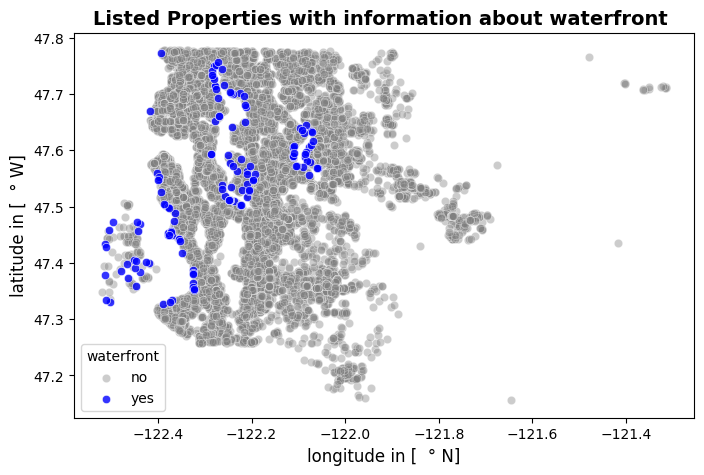

In [53]:
# first grey (no waterfront)
sns.scatterplot(
    data=filtered_waterfront[filtered_waterfront["waterfront"] == 0],
    x="long",
    y="lat",
    color="grey",
    marker="o",
    alpha=0.4,
    label="no",
    zorder=1
)

#waterfront =
sns.scatterplot(
    data=filtered_waterfront[filtered_waterfront["waterfront"] == 1],
    x="long",
    y="lat",
    color="blue",
    marker="o",
    alpha=0.8,
    label="yes",
    zorder=2   
)

plt.legend(title="waterfront")
plt.title("Listed Properties with information about waterfront ", fontsize=14, weight="bold")
plt.xlabel("longitude in [  ° N]", fontsize=12)
plt.ylabel("latitude in [  ° W]", fontsize=12)
plt.show()

It looks like the houses on the island are more isolated than the ones at the coast or at the lakes.

To create an presentation for our client. In the following a plot with all listed houses and all listed houses with knowledge about waterfront is created.

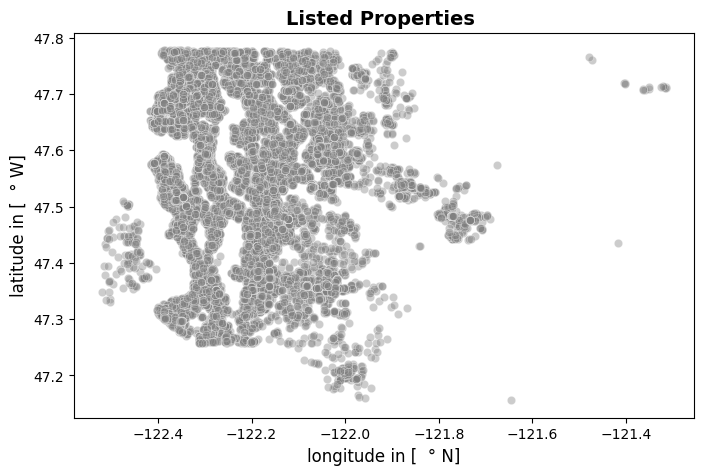

In [58]:
#all Houses we have in our portfolio
sns.scatterplot(
    df_houses,
    x="long",
    y="lat",
    color="grey",
    marker="o",
    alpha=0.4,
    zorder=1
)

plt.title("Listed Properties ", fontsize=14, weight="bold")
plt.ylabel("latitude in [  ° W]", fontsize=12)
plt.xlabel("longitude in [  ° N]", fontsize=12)
plt.show()

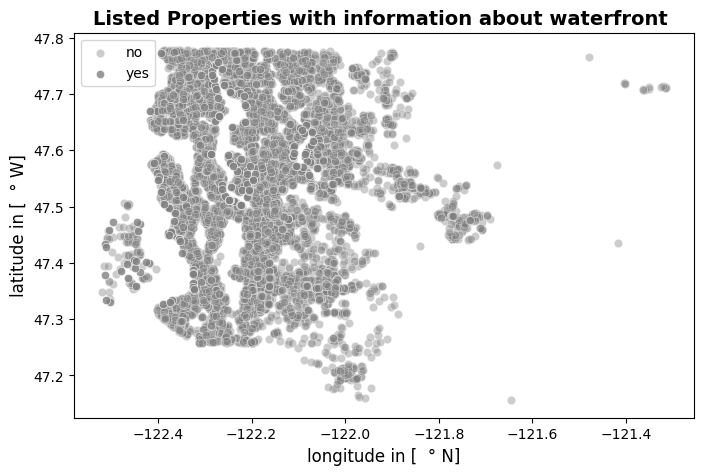

In [60]:
#all listed properties with waterfront

sns.scatterplot(
    data=filtered_waterfront[filtered_waterfront["waterfront"] == 0],
    x="long",
    y="lat",
    color="grey",
    marker="o",
    alpha=0.4,
    label="no",
    zorder=1
)
sns.scatterplot(
    data=filtered_waterfront[filtered_waterfront["waterfront"] == 1],
    x="long",
    y="lat",
    color="grey",
    marker="o",
    alpha=0.8,
    label="yes",
    zorder=2   
)

plt.title("Listed Properties with information about waterfront ", fontsize=14, weight="bold")
plt.ylabel("latitude in [  ° W]", fontsize=12)
plt.xlabel("longitude in [  ° N]", fontsize=12)
plt.show()

To search for a suitable house and see the information about the house, this same plot is created with plotly. This allows to hover the data and see the informations like price and sqarefeet. Only the houses with known waterfront are displayed.

In [54]:
import plotly.express as px

fig = px.scatter(
    filtered_waterfront[filtered_waterfront["waterfront"] == 1],
    x="long",
    y="lat",
    color="price",
    hover_data={
        "sqft_living": True,
        "price": ":$"
    },
    labels={
        "long": "longitude [° W]",
        "lat": "latitude [° N]",
        "price": "price (USD)",
        "sqft_living": "living space (sqft)"
    },
    title="Waterfront Properties Colored by Price",
    color_continuous_scale=["#3B4CC0", "#D3D3D3", "#E68310"],
    opacity=0.7
)

fig.update_layout(
    plot_bgcolor="white",      # no background
    paper_bgcolor="white",     # no frame
    coloraxis_colorbar=dict(title="Price (USD)"),
    width=800,
    height=600,
    legend_title_text="",
    font=dict(size=12)
)

#optical like seaborn to create a coherent presentation 
fig.update_xaxes(
    showline=True,
    linewidth=1,
    linecolor="black",
    mirror=True,               # lines above and below
    ticks="outside",
    showgrid=False
)
fig.update_yaxes(
    showline=True,
    linewidth=1,
    linecolor="black",
    mirror=True,               # lines left and right
    ticks="outside",
    showgrid=False
)

fig.show()



<span style="color:darkred">
=> There is no correlation between price and the combination of waterfront and isolation
</span>

This is good, then we will be able to show Larry budgetfriendly houses with waterfront that are isolated.

---


### With this plot(s) we are able to make suitable house suggestions for Larry, which are:


In [69]:
print(df_houses[(df_houses["long"] == 122.503) & (df_houses["lat"] == 47.331194)])

print(df_houses[(df_houses["long"] == -122.497) & (df_houses["lat"] == 47.4728)])

print(df_houses[(df_houses["long"] == -122.248) & (df_houses["lat"] == 47.5117)])


Empty DataFrame
Columns: [id, bedrooms, bathrooms, sqft_living, sqft_lot, floors, waterfront, view, condition, grade, sqft_above, sqft_basement, yr_built, yr_renovated, zipcode, lat, long, sqft_living15, sqft_lot15, date, price, has_basement]
Index: []

[0 rows x 22 columns]
               id  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
14813  2423029009     2.000      2.000     1494.000 19271.000   2.000   

       waterfront  view  condition  grade  ...  yr_built  yr_renovated  \
14813       1.000 4.000          3      7  ...      1943     19970.000   

       zipcode    lat     long  sqft_living15  sqft_lot15       date  \
14813    98070 47.473 -122.497       1494.000   43583.000 2014-06-17   

           price has_basement  
14813 465000.000         True  

[1 rows x 22 columns]
              id  bedrooms  bathrooms  sqft_living  sqft_lot  floors  \
3164  8073000495     2.000      1.000     1160.000 17635.000   1.000   

      waterfront  view  condition  grade  ...  yr_b

---


Further insides can be gained, if other plots are executed. The following example displays the price against the living space of all houses with waterfront. The colorgradient displays the longitude. It becomes obvious (through their location in longitude) that houses at the lower price range are located on the island or the coast while the expensive ones are at a lake. 

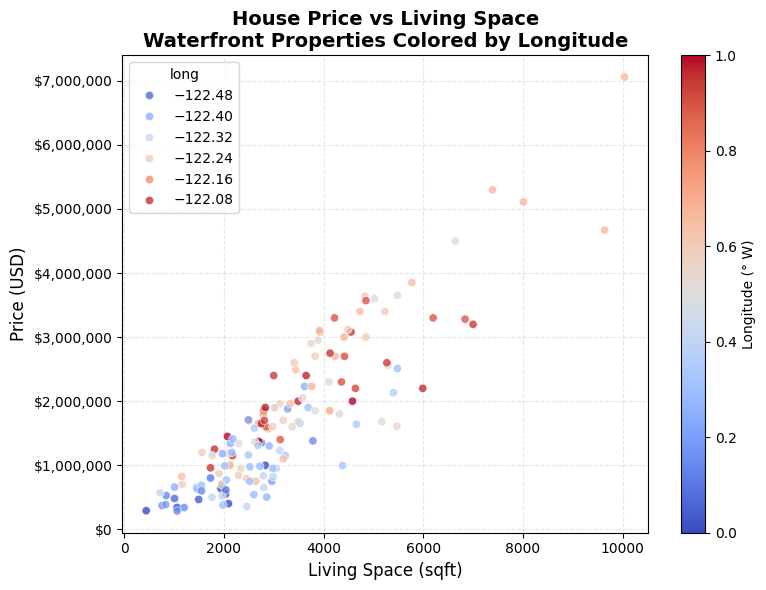

In [61]:
plt.figure(figsize=(8, 6))

# Scatterplot mit Farbverlauf basierend auf Longitude
sns.scatterplot(
    data=filtered_waterfront[filtered_waterfront["waterfront"] == 1],
    x="sqft_living",
    y="price",
    hue="long",                # 🔹 Farbe nach Längengrad
    palette="coolwarm",        # 🔹 Farbverlauf (blau → rot)
    marker="o",
    alpha=0.8,
    zorder=2
)

# Achsentitel und Layout
plt.title("House Price vs Living Space\nWaterfront Properties Colored by Longitude", fontsize=14, weight="bold")
plt.xlabel("Living Space (sqft)", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)

# 💡 Y-Achse mit Preisformat
formatter = FuncFormatter(lambda x, _: f"${x:,.0f}")
plt.gca().yaxis.set_major_formatter(formatter)

plt.grid(True, linestyle="--", alpha=0.3)
plt.tight_layout()

# 🔹 Farbskala mit Titel
cbar = plt.colorbar(plt.cm.ScalarMappable(cmap="coolwarm"), ax=plt.gca(), orientation="vertical")
cbar.set_label("Longitude (° W)")

plt.show()